In [1]:
#Importing packages
import requests
import bs4 as bs
import pandas as pd
import re
import datetime
from datetime import datetime

In [2]:
#Things to import
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time, tqdm, json, re, requests, os, csv
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import snscrape.modules.twitter as sntwitter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [37]:
# Getting the URL
url = 'https://en.wikipedia.org/wiki/List_of_post%E2%80%932016_election_Donald_Trump_rallies'
response = requests.get(url, headers={'name': 'Laurits Harbom Marcussen', 'email': 'zhg932@alumni.ku.dk'})
soup = bs.BeautifulSoup(response.content, 'lxml') # Get the HTML of the website
tables = soup.find_all('table')

In [38]:
#Converts html's to dataframes, convert lists to dataframe
df=pd.read_html(str(tables))
df1=pd.DataFrame(df[8])
df2=pd.DataFrame(df[9])

#Isolate the "Date of rally2 columns, and combine the 2 tables
dates = pd.concat([df1["Date of rally"], df2["Date of rally"]])
dates = dates.reset_index(drop=True)

#Cleans wiki-data
def clean():
    for i in range(len(dates)):
        dates[i] = re.sub(r'\[\d+\]', '', dates[i])
        date_list = dates[i].split(',') # # Removing the weekday and the comma from the strings by splitting the strings and merging them again
        dates[i] = ''.join(date_list[1:])
        dates[i] = pd.to_datetime(dates[i]).strftime('%Y-%m-%d') # Converting to datetime format
    return dates
clean()

0     2020-06-20
1     2020-06-23
2     2020-08-17
3     2020-08-17
4     2020-08-18
         ...    
65    2020-11-02
66    2020-11-02
67    2020-12-05
68    2021-01-04
69    2021-01-06
Name: Date of rally, Length: 70, dtype: object

In [39]:
#Craeting a list of all the dates we wanna analyze
all_dates = pd.date_range(start='5/21/2020', end='2/05/2021')
date_list = all_dates.strftime('%Y-%m-%d')
s = pd.Series(date_list)

In [40]:
#Comparing the list of all dates and the list of rally dates, and making a binary list of coinciding dates
binary_list = []
for i in s:
    if i in dates.values: 
        binary_list.append(1)
    else: 
        binary_list.append(0)
binaries = pd.Series(binary_list)

In [41]:
#Making a combined list
rallies = [[s[i], binaries[i]] for i in range(len(binary_list))]

In [42]:
#Get a dictionary with the frequency of rallies each day
date_frq = {}
#fill the dictionary
for date in dates:
    cnt = 0
    for d in dates:
        if date == d:
            cnt += 1
        date_frq[date] = cnt

In [43]:
for i in range(len(rallies)):
    if rallies[i][0] in date_frq.keys():
        rallies[i].append(date_frq[rallies[i][0]])
    else:
        rallies[i].append(0)

In [44]:
rallies[:5]

[['2020-05-21', 0, 0],
 ['2020-05-22', 0, 0],
 ['2020-05-23', 0, 0],
 ['2020-05-24', 0, 0],
 ['2020-05-25', 0, 0]]

In [45]:
#Making a dataframe with the dates
df_rally = pd.DataFrame(rallies, columns=['date', 'rally', 'amount'])

In [46]:
#create a date column with datetime
df_rally['date'] = pd.to_datetime(df_rally['date'])

In [47]:
df_rally

,date,rally,amount
0,2020-05-21,0,0
1,2020-05-22,0,0
2,2020-05-23,0,0
3,2020-05-24,0,0
4,2020-05-25,0,0
...,...,...,...
256,2021-02-01,0,0
257,2021-02-02,0,0
258,2021-02-03,0,0
259,2021-02-04,0,0


In [48]:
last_rally = 79
days_since_list = []

#days_since = last_rally 
for rally in df_rally['rally']:
    if rally == 1:
        last_rally = 0
    else:
        last_rally += 1
    days_since_list.append(last_rally)
#Insert into dataframe
df_rally['days_since_last_rally'] = days_since_list

In [49]:
#Get a reversed dataframe
rally_reverse = df_rally.sort_values(by='date', ascending=False).copy()

In [50]:
days_to_next = []
next_rally = 139
for rally in rally_reverse['rally']:
    if rally == 1:
        next_rally = 0
    else:
        next_rally += 1
    days_to_next.append(next_rally)
days_to_next = list(reversed(days_to_next))
df_rally['days_to_next_rally'] = days_to_next

In [51]:
df_rally.iloc[20:50]

,date,rally,amount,days_since_last_rally,days_to_next_rally
20,2020-06-10,0,0,100,10
21,2020-06-11,0,0,101,9
22,2020-06-12,0,0,102,8
23,2020-06-13,0,0,103,7
24,2020-06-14,0,0,104,6
25,2020-06-15,0,0,105,5
26,2020-06-16,0,0,106,4
27,2020-06-17,0,0,107,3
28,2020-06-18,0,0,108,2
29,2020-06-19,0,0,109,1


In [52]:
#Get the rallies within three days of the given index
within_3_days = []
cnt = 0
for i in range(len(rallies)):
    for d_r in rallies[(i-3):(i+3)]:
        cnt += d_r[2]
    within_3_days.append(cnt)
    cnt = 0
df_rally['within_7_days'] = within_3_days

In [53]:
df_rally.iloc[25:40]

,date,rally,amount,days_since_last_rally,days_to_next_rally,within_7_days
25,2020-06-15,0,0,105,5,0
26,2020-06-16,0,0,106,4,0
27,2020-06-17,0,0,107,3,0
28,2020-06-18,0,0,108,2,1
29,2020-06-19,0,0,109,1,1
30,2020-06-20,1,1,0,0,1
31,2020-06-21,0,0,1,2,2
32,2020-06-22,0,0,2,1,2
33,2020-06-23,1,1,0,0,2
34,2020-06-24,0,0,1,54,1


## Run Twitter notebook and import results

In [54]:
#Load tweet dataframe from csv
df_combined_tweets = pd.read_csv('combined_tweets.csv')
df_combined_tweets.head()
#Convert date to datetime
df_combined_tweets['date'] = pd.to_datetime(df_combined_tweets['date'])
#Merge the two dataframes
merged_df = pd.merge(df_combined_tweets, df_rally, on='date', how='left')
merged_df.iloc[-120:-70]

,date,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day,rally,amount,days_since_last_rally,days_to_next_rally,within_7_days
124,2020-10-09,58,-0.545047,4.0,0.578750,49.0,-0.692402,2020-10-09,0,0,9,3,0
125,2020-10-10,64,-0.521858,7.0,0.377943,53.0,-0.680085,2020-10-10,0,0,10,2,1
126,2020-10-11,16,-0.452138,1.0,0.496600,12.0,-0.644233,2020-10-11,0,0,11,1,2
127,2020-10-12,13,-0.198369,3.0,0.238600,5.0,-0.658920,2020-10-12,1,1,0,0,3
128,2020-10-13,26,0.166862,16.0,0.388519,4.0,-0.469475,2020-10-13,1,1,0,0,4
129,2020-10-14,11,0.046491,3.0,0.610400,3.0,-0.439933,2020-10-14,1,1,0,0,6
130,2020-10-15,13,0.033738,7.0,0.416114,4.0,-0.618550,2020-10-15,1,1,0,0,8
131,2020-10-16,2,-0.666850,NaN,NaN,2.0,-0.666850,2020-10-16,1,2,0,0,8
132,2020-10-17,4,-0.153100,NaN,NaN,1.0,-0.612400,2020-10-17,1,2,0,0,9
133,2020-10-18,5,-0.304260,2.0,0.231950,3.0,-0.661733,2020-10-18,1,1,0,0,9


In [55]:
#Saving the merged dataframe as a csv
merged_df.to_csv('tweet_data.csv', encoding='utf8')

In [3]:
merged_df = pd.read_csv('tweet_data.csv', encoding='utf8')

In [4]:
merged_df.drop('Unnamed: 0', axis=1, inplace=True)
merged_df

,date,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day,rally,amount,days_since_last_rally,days_to_next_rally,within_7_days
0,2020-05-21,7,-0.101471,1.0,0.381800,3.0,-0.364033,2020-05-21,0,0,80,30,0
1,2020-05-22,5,-0.530020,NaN,NaN,4.0,-0.662525,2020-05-22,0,0,81,29,0
2,2020-05-23,3,-0.028400,2.0,0.364700,1.0,-0.814600,2020-05-23,0,0,82,28,0
3,2020-05-24,4,-0.058650,1.0,0.623900,1.0,-0.858500,2020-05-24,0,0,83,27,0
4,2020-05-25,1,0.522900,1.0,0.522900,NaN,NaN,2020-05-25,0,0,84,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2021-02-01,143,-0.076739,54.0,0.444609,58.0,-0.603148,2021-02-01,0,0,26,144,0
240,2021-02-02,148,-0.102641,44.0,0.445641,68.0,-0.511751,2021-02-02,0,0,27,143,0
241,2021-02-03,215,-0.034601,56.0,0.538586,66.0,-0.569697,2021-02-03,0,0,28,142,0
242,2021-02-04,148,-0.034109,32.0,0.400462,35.0,-0.510371,2021-02-04,0,0,29,141,0


## Exploritory plots

<AxesSubplot:xlabel='date', ylabel='total_avg'>

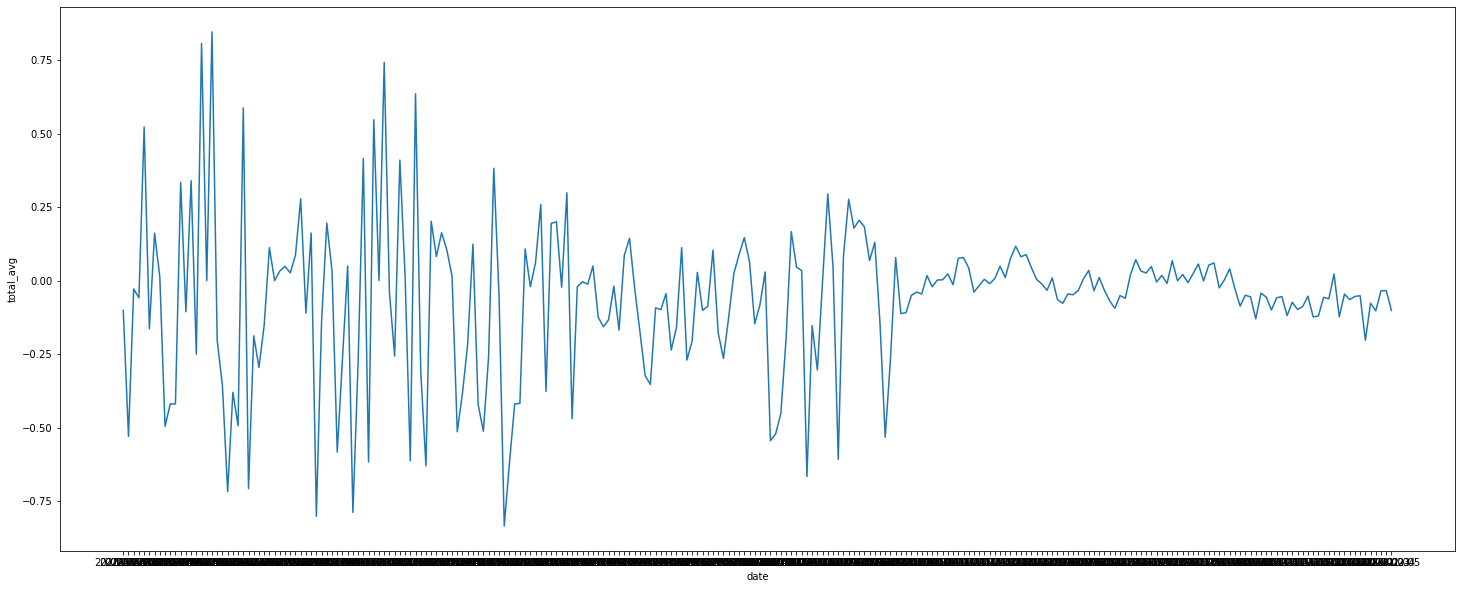

In [ ]:
#Average total sentiment over time
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(x=merged_df['date'], y=merged_df['total_avg'])

<AxesSubplot:xlabel='date', ylabel='negative_avg'>

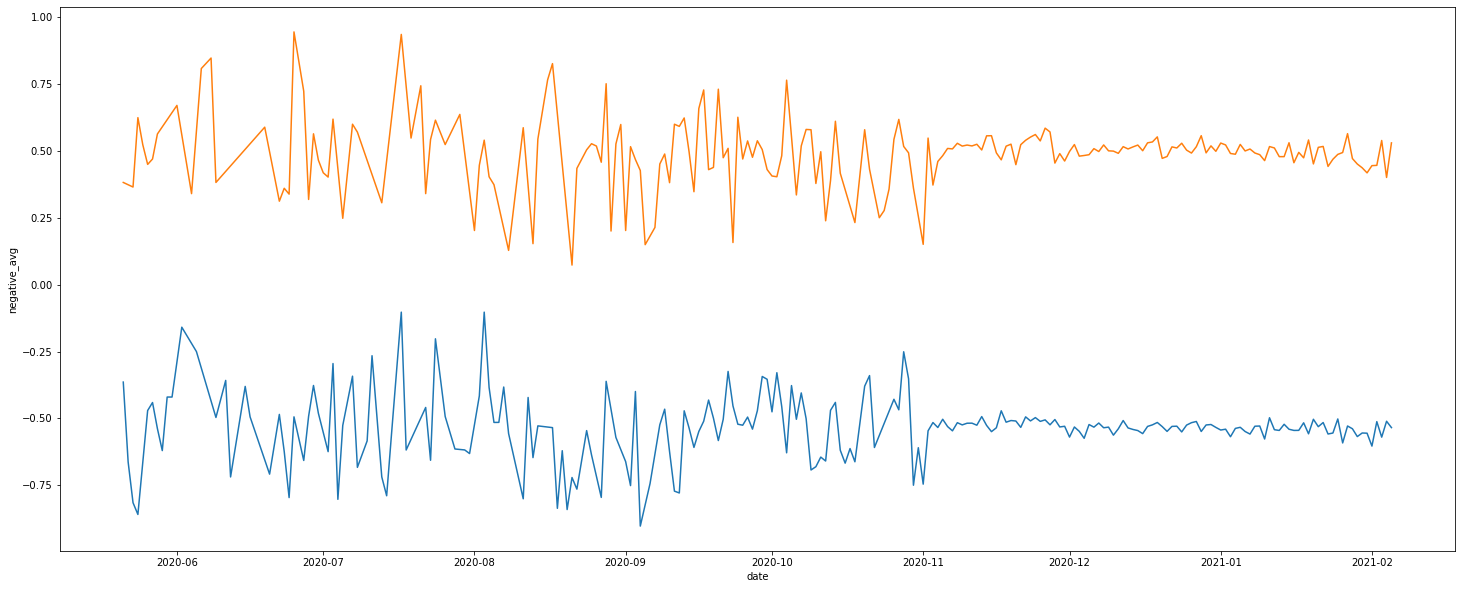

In [ ]:
#Avg positive and negative sentiment over time
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(x=merged_df['date'], y=merged_df['negative_avg'])
sns.lineplot(x=merged_df['date'], y=merged_df['positive_avg'])

<AxesSubplot:xlabel='date', ylabel='total_avg'>

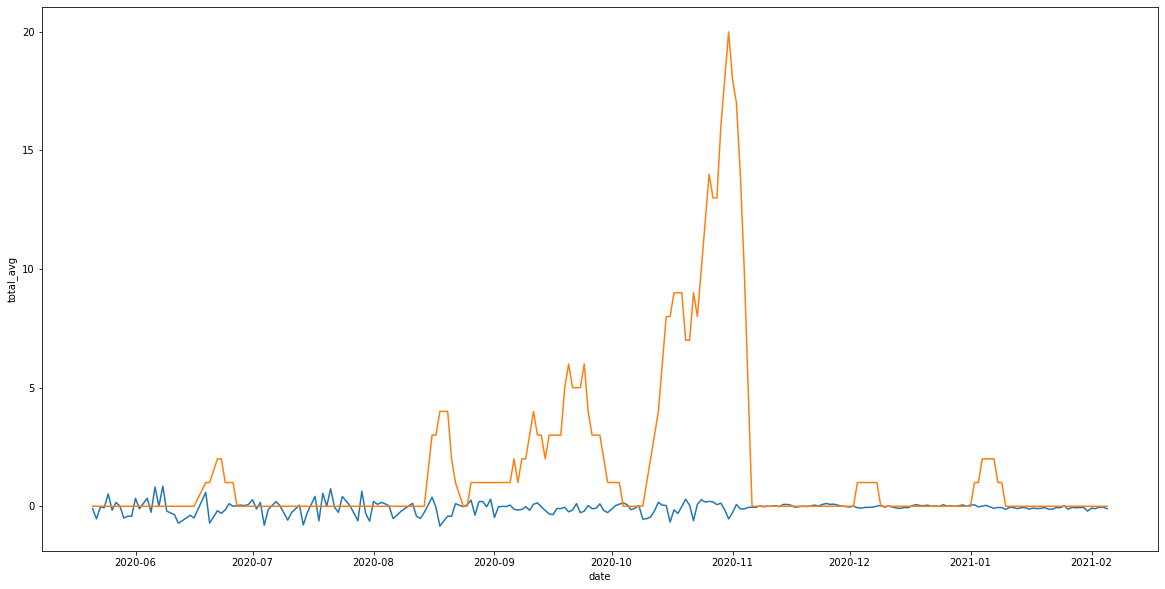

In [ ]:
#Average sentiment in relation to rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=merged_df['date'], y=merged_df['total_avg'])
sns.lineplot(x=merged_df['date'], y=merged_df['within_7_days'])

<AxesSubplot:xlabel='date', ylabel='negative_avg'>

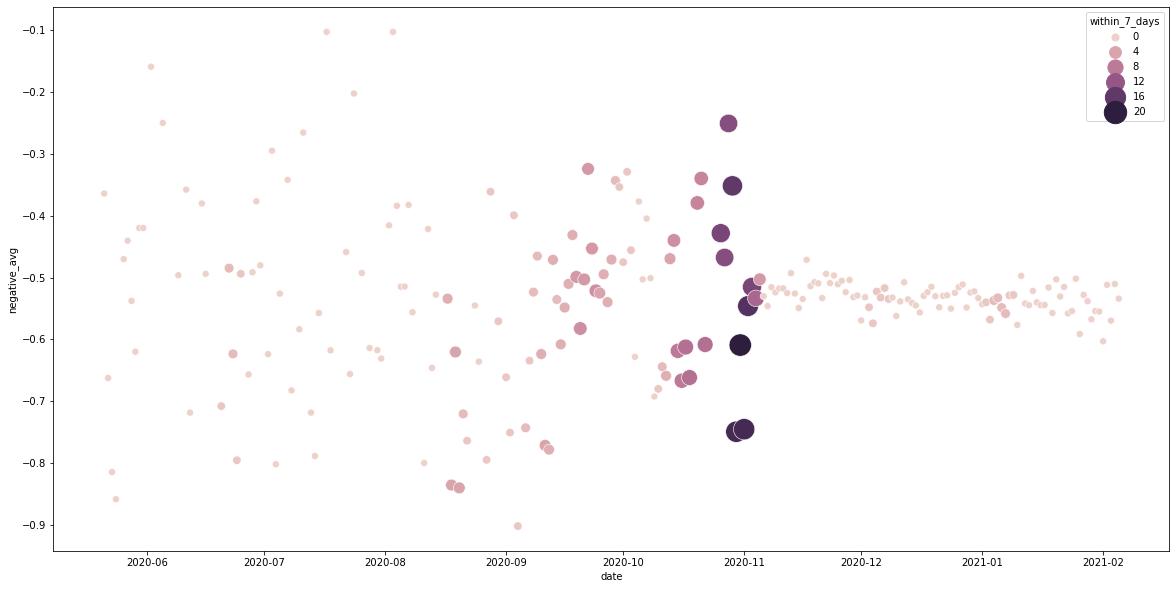

In [511]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=merged_df['date'], y=merged_df['negative_avg'], hue=merged_df['within_7_days'], size=merged_df['within_7_days'], sizes=(50, 500))

<AxesSubplot:xlabel='rally', ylabel='total_avg'>

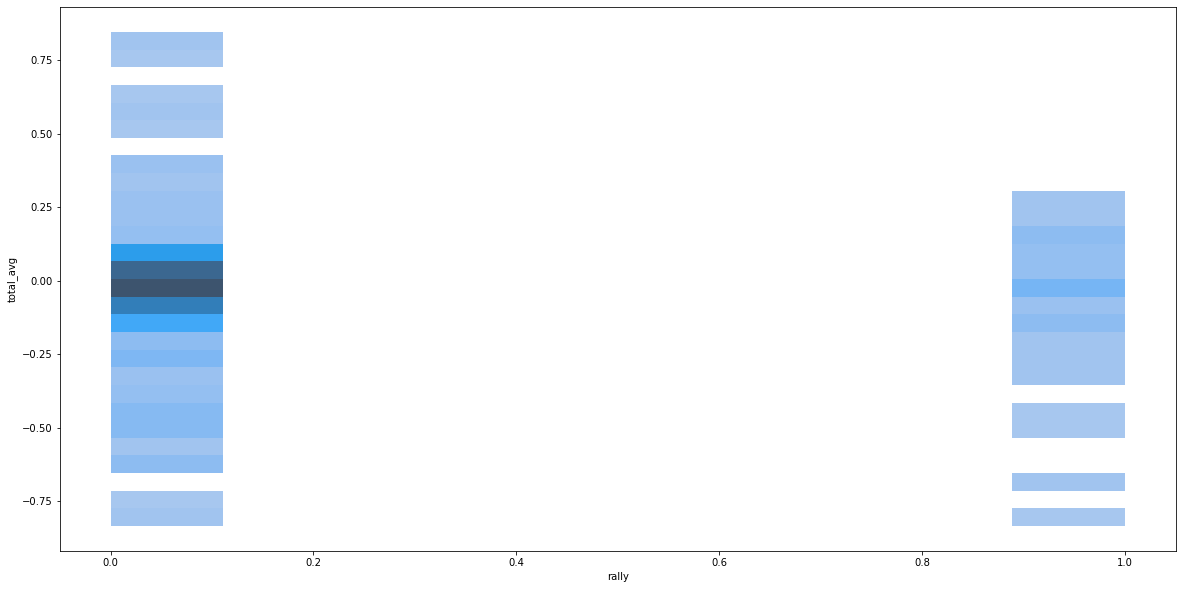

In [38]:
#Showing the distribution of values on days with and without rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(x=merged_df['rally'], y=merged_df['total_avg'])

<AxesSubplot:xlabel='within_7_days', ylabel='total_avg'>

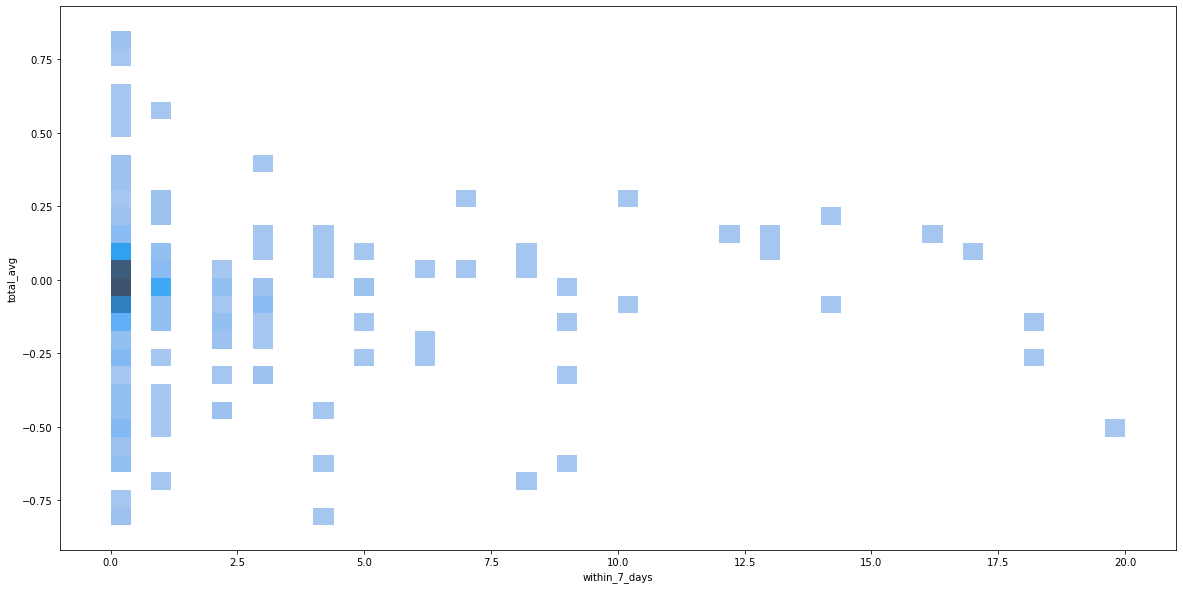

In [514]:
#Showing the distribution of values on days with and without rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(x=merged_df['within_7_days'], y=merged_df['total_avg'])

### Looking at the period from the election to the storm

In [516]:
merged_df.loc[merged_df['date'] > "2020-11-02"]

,date,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day,rally,amount,days_since_last_rally,days_to_next_rally,within_7_days
149,2020-11-03,457,-0.112596,122.0,0.372067,188.0,-0.515152,2020-11-03,0,0,1,32,14
150,2020-11-04,1743,-0.108722,480.0,0.460222,769.0,-0.533693,2020-11-04,0,0,2,31,10
151,2020-11-05,7003,-0.050578,2166.0,0.481875,2780.0,-0.502855,2020-11-05,0,0,3,30,5
152,2020-11-06,8368,-0.039067,2829.0,0.508872,3332.0,-0.530166,2020-11-06,0,0,4,29,0
153,2020-11-07,9077,-0.045189,2926.0,0.507111,3468.0,-0.546132,2020-11-07,0,0,5,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2021-02-01,143,-0.076739,54.0,0.444609,58.0,-0.603148,2021-02-01,0,0,26,144,0
240,2021-02-02,148,-0.102641,44.0,0.445641,68.0,-0.511751,2021-02-02,0,0,27,143,0
241,2021-02-03,215,-0.034601,56.0,0.538586,66.0,-0.569697,2021-02-03,0,0,28,142,0
242,2021-02-04,148,-0.034109,32.0,0.400462,35.0,-0.510371,2021-02-04,0,0,29,141,0


In [98]:
election_df = merged_df.loc[(merged_df['date'] > "2020-11-02") & (merged_df['date'] < "2021-01-20")].copy()

<AxesSubplot:xlabel='date', ylabel='tweet_count'>

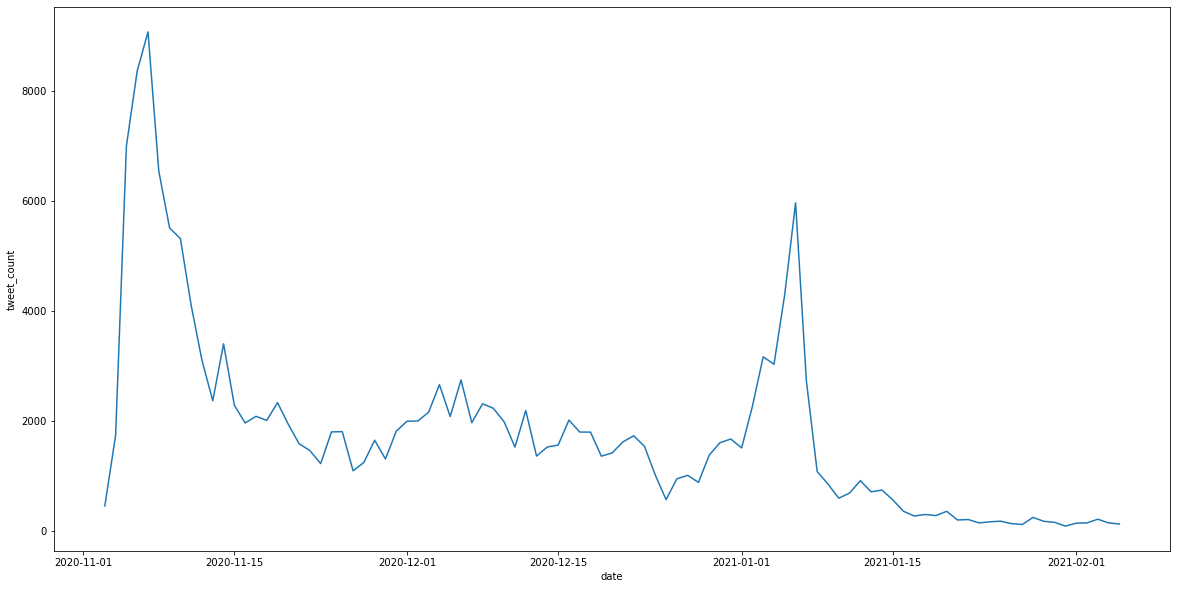

In [518]:
#Frequency of tweets over time
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=election_df['date'], y=election_df['tweet_count'])

<AxesSubplot:xlabel='date', ylabel='total_avg'>

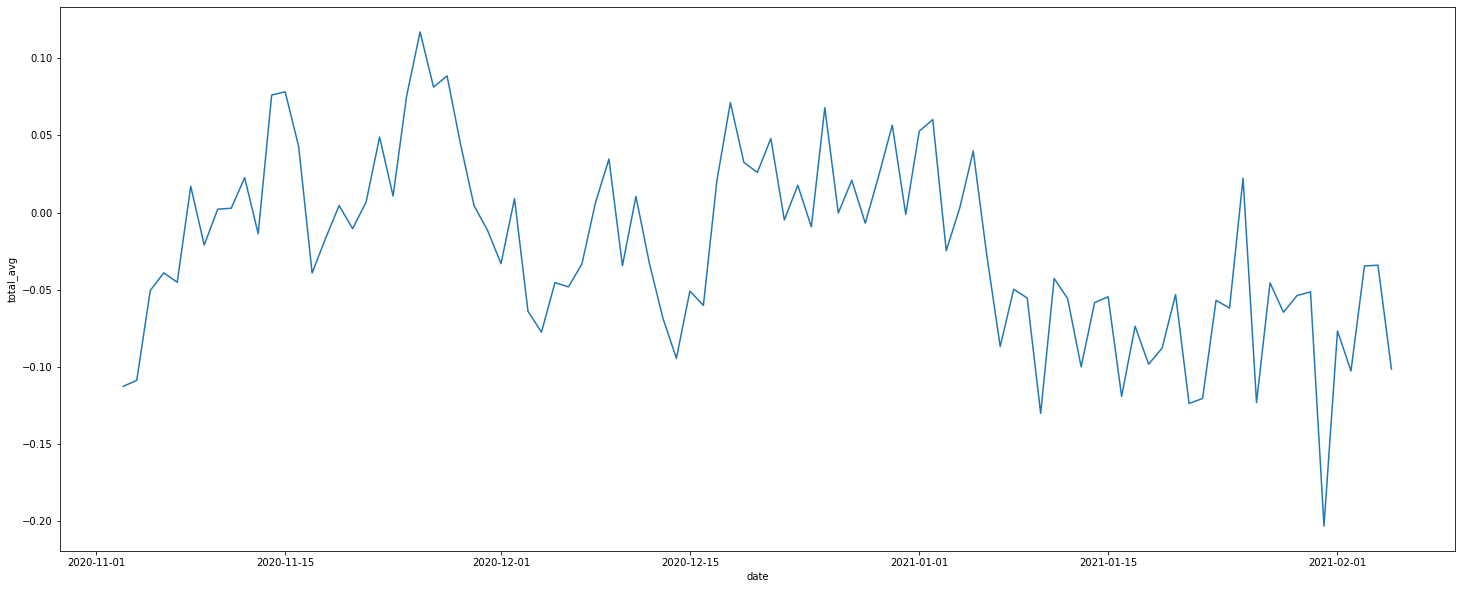

In [519]:
#Average total sentiment over time
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(x=election_df['date'], y=election_df['total_avg'])

<AxesSubplot:xlabel='date', ylabel='negative_avg'>

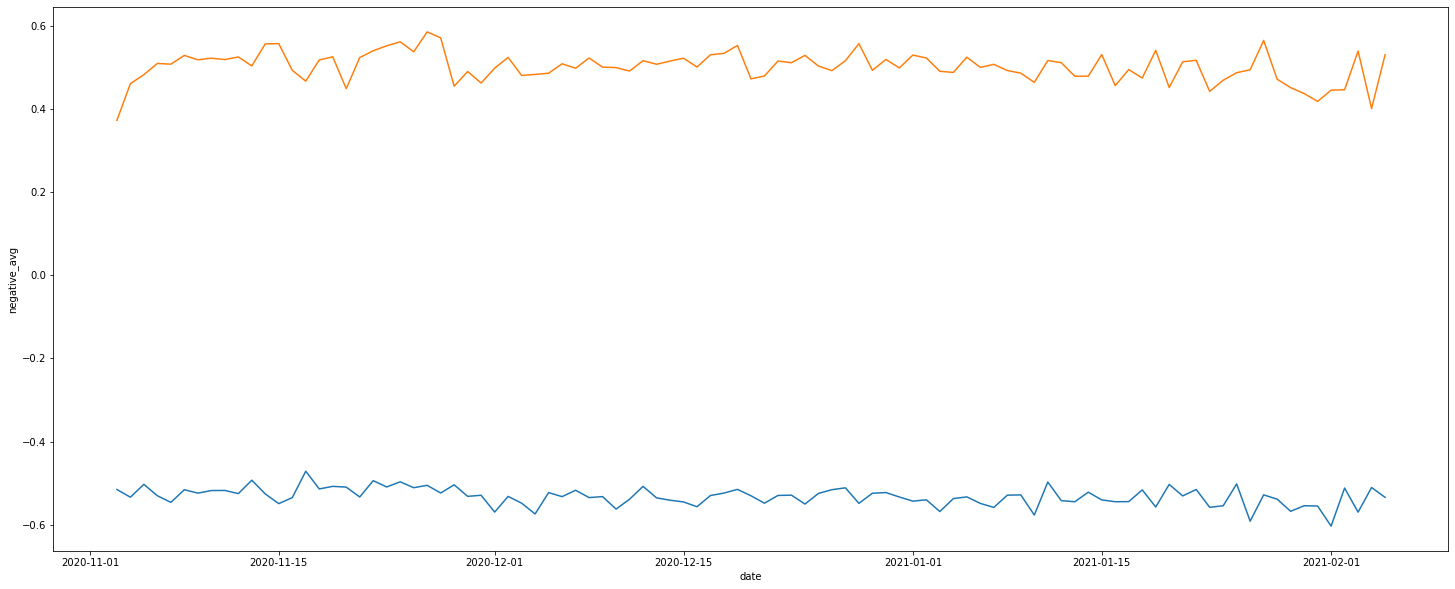

In [520]:
#Avg positive and negative sentiment over time
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(x=election_df['date'], y=election_df['negative_avg'])
sns.lineplot(x=election_df['date'], y=election_df['positive_avg'])

<AxesSubplot:xlabel='date', ylabel='total_avg'>

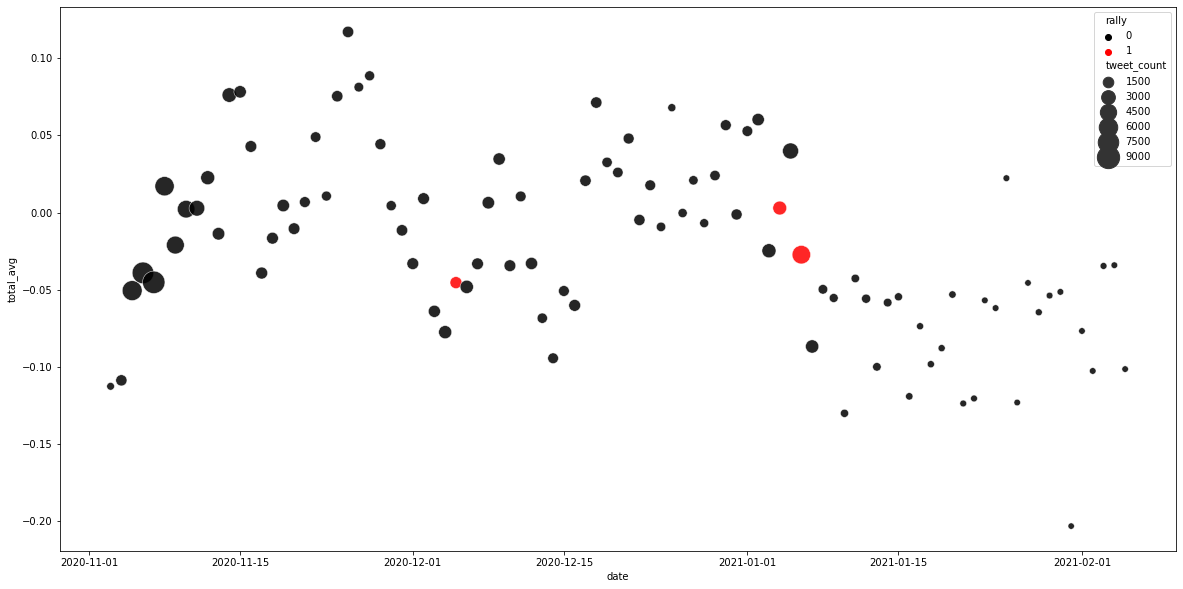

In [521]:
#Average sentiment in relation to time, frequency, and rallies
#Our hypothesis was, that the red dots (the days where there were rallies, would have the lowest values over all. However, there does not appear to be an obvious decrease in sentiment only based on rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=election_df['date'], y=election_df['total_avg'], hue=election_df['rally'], palette=['black', 'red'], size=election_df['tweet_count'], sizes=(40, 500), alpha=0.85)

<AxesSubplot:xlabel='days_since_last_rally', ylabel='negative_avg'>

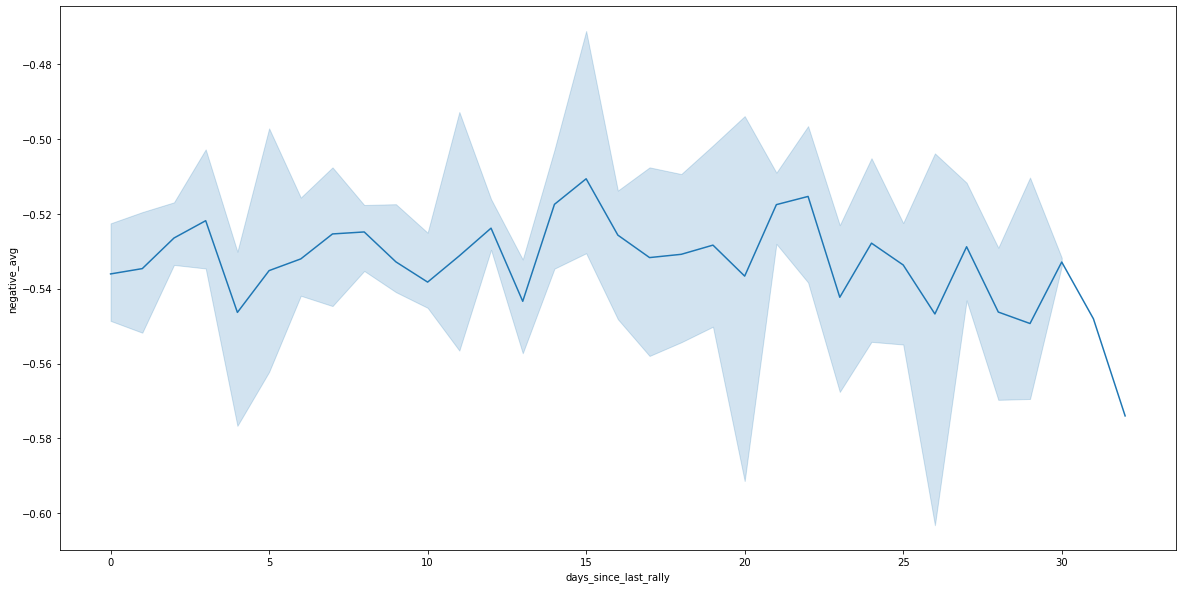

In [522]:
#Correlation between days since last rally and average negative sentiment -> seems to be non-existant
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=election_df['days_since_last_rally'], y=election_df['negative_avg'])

<AxesSubplot:xlabel='date', ylabel='negative_avg'>

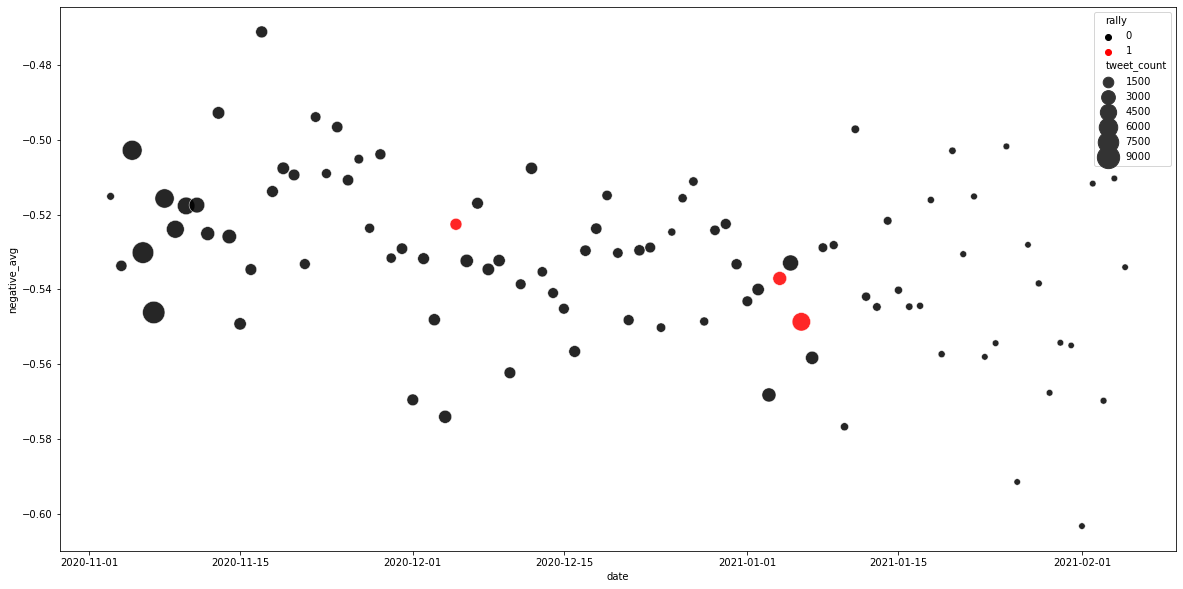

In [523]:
#Average sentiment in relation to time, frequency, and rallies
#Our hypothesis was, that the red dots (the days where there were rallies, would have the lowest values over all. However, there does not appear to be an obvious decrease in sentiment only based on rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=election_df['date'], y=election_df['negative_avg'], hue=election_df['rally'], palette=['black', 'red'], size=election_df['tweet_count'], sizes=(40, 500), alpha=0.85)

## Descriptive plots

Descriptive Statistics

Frequency & Sentiment over time

Frequency, Sentiment, & within 7 days over time

Maybe also just rallies

#### Descriptive Statistics

In [17]:
tweets_for_bag.head(2)

,cleaned text,sentiment_score,date
0,prediction: every primetime host tonight will...,-0.6486,2021-02-05
1,i don't understand - since we all know the ele...,-0.4939,2021-02-05


In [16]:
tweets_for_bag.describe()

,sentiment_score
count,172455.000000
mean,-0.010555
std,0.494242
min,-0.997200
25%,-0.438900
50%,0.000000
75%,0.401900
max,0.985300


In [19]:
combined = tweets_for_bag.groupby(['date'])['sentiment_score'].describe()

In [21]:
combined

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2020-05-21,7.0,-0.101471,0.293955,-0.5080,-0.292050,0.0000,0.000000,0.3818
2020-05-22,5.0,-0.530020,0.301074,-0.7177,-0.709600,-0.6331,-0.589700,0.0000
2020-05-23,3.0,-0.028400,0.699302,-0.8146,-0.304700,0.2052,0.364700,0.5242
2020-05-24,4.0,-0.058650,0.608965,-0.8585,-0.214625,0.0000,0.155975,0.6239
2020-05-25,1.0,0.522900,NaN,0.5229,0.522900,0.5229,0.522900,0.5229
...,...,...,...,...,...,...,...,...
2021-02-01,143.0,-0.076739,0.508613,-0.9601,-0.532900,0.0000,0.361200,0.8472
2021-02-02,148.0,-0.102641,0.458078,-0.9524,-0.455900,0.0000,0.207825,0.9030
2021-02-03,215.0,-0.034601,0.452838,-0.9528,-0.356100,0.0000,0.138900,0.9256


#### Descriptive Plots

In [7]:
merged_df.head(2)

,date,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day,rally,amount,days_since_last_rally,days_to_next_rally,within_7_days
0,2020-05-21,7,-0.101471,1.0,0.3818,3.0,-0.364033,2020-05-21,0,0,80,30,0
1,2020-05-22,5,-0.530020,NaN,NaN,4.0,-0.662525,2020-05-22,0,0,81,29,0


<AxesSubplot:xlabel='date', ylabel='total_avg'>

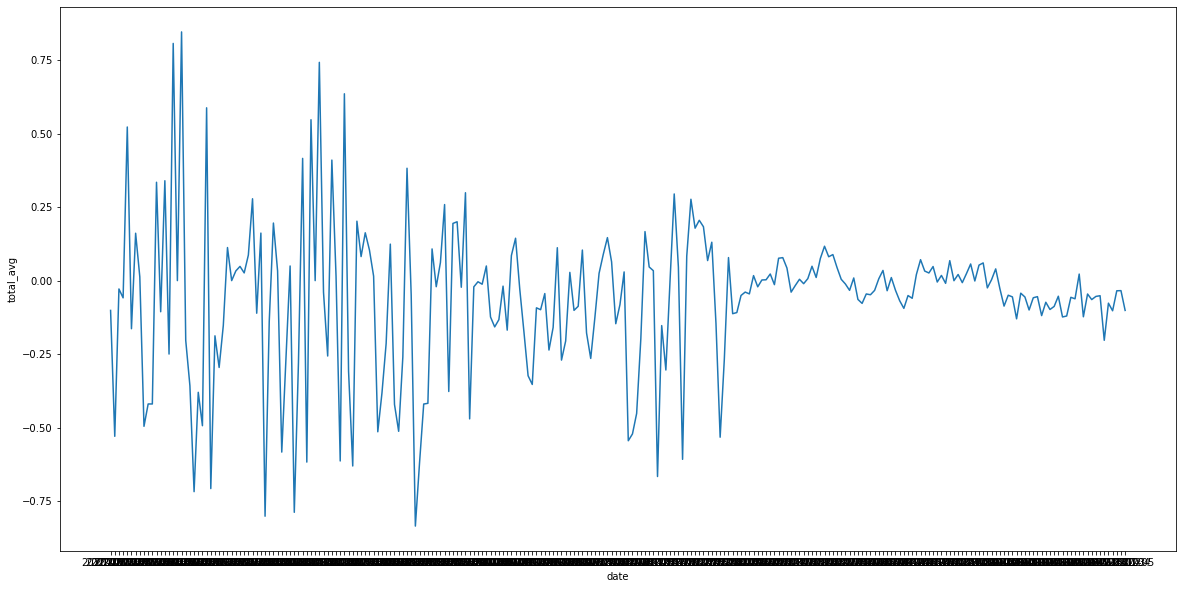

In [8]:
#Sentiment over time
"""Here we see the development of the average twitter sentiment over time. We see that up to November 2020, the sentiment is very aratic. However, afterwards, the sentiment
is very balanced and close to neutral, deviating only partially. This is most likely due to the difference in frequency of tweets, which can be seen in the next plot."""
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=merged_df['date'], y=merged_df['total_avg'])

<AxesSubplot:xlabel='date', ylabel='tweet_count'>

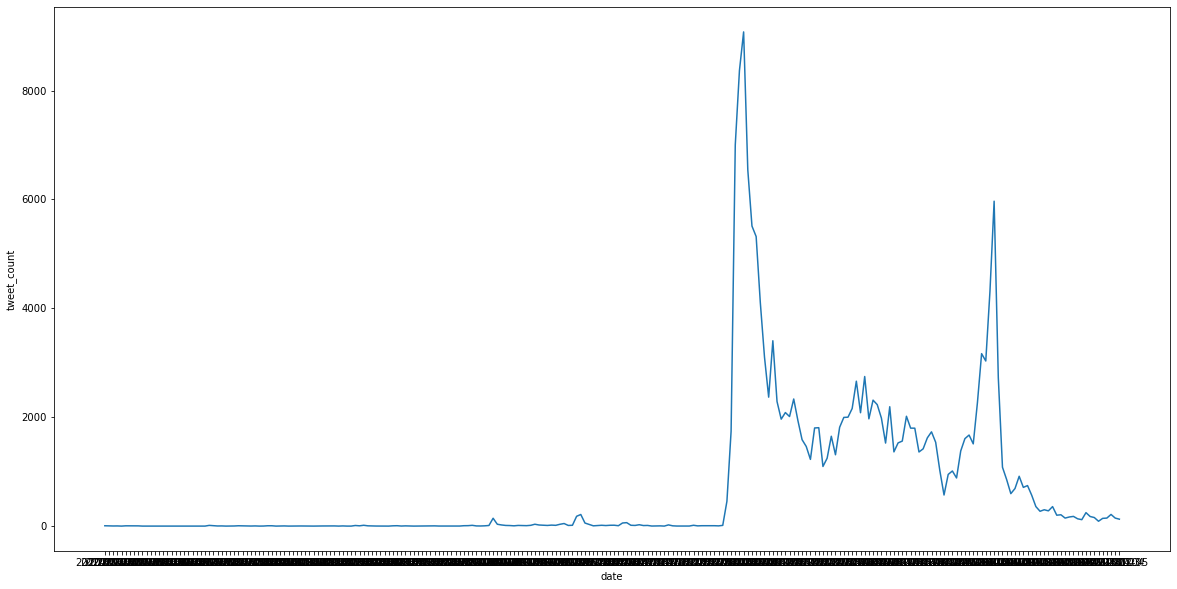

In [9]:
#Frequency over time
"""Here we see the frequency of tweets, where the frequency sky rockets right around the election in November 2020, and has second peak right around January 6th."""
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=merged_df['date'], y=merged_df['tweet_count'])

<AxesSubplot:xlabel='date', ylabel='total_avg'>

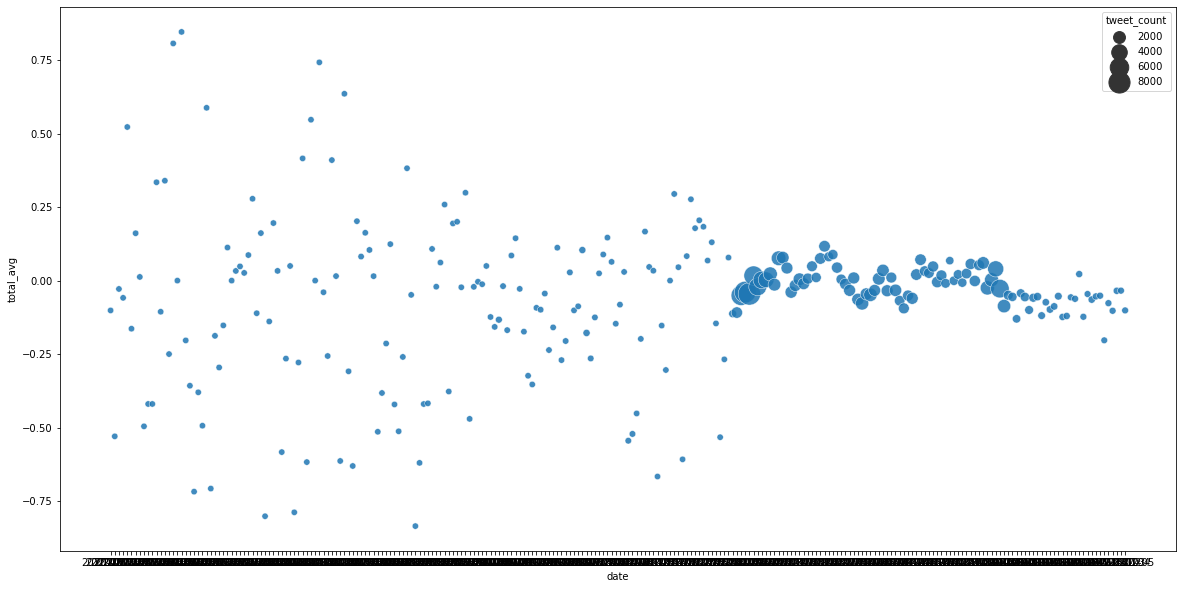

In [10]:
#Frequency & Sentiment
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=merged_df['date'], y=merged_df['total_avg'], size=merged_df['tweet_count'], sizes=(40, 500), alpha=0.85)

<AxesSubplot:xlabel='date', ylabel='total_avg'>

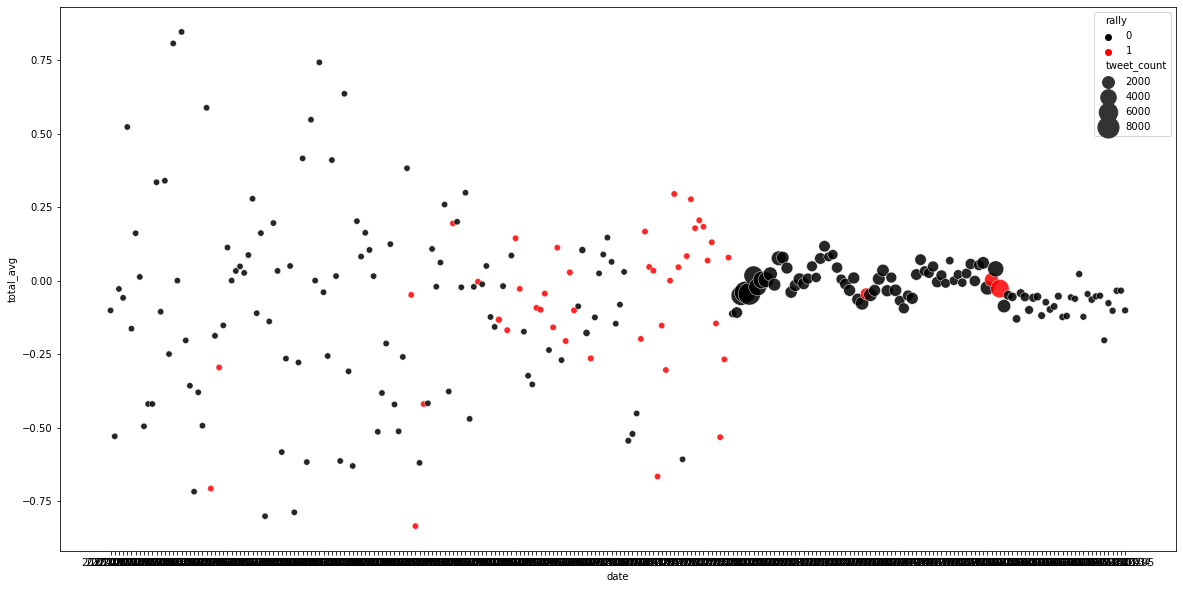

In [23]:
#Frequency & Sentiment, with the rallies
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=merged_df['date'], y=merged_df['total_avg'], hue=merged_df['rally'], palette=['black', 'red'], size=merged_df['tweet_count'], sizes=(40, 500), alpha=0.85)

<AxesSubplot:xlabel='within_7_days', ylabel='total_avg'>

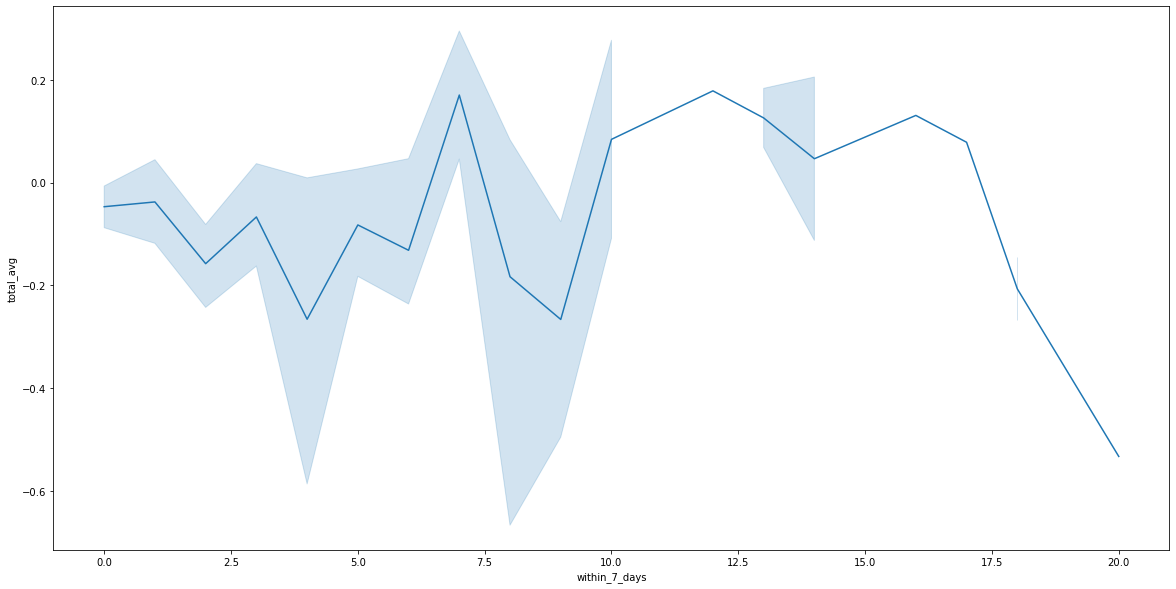

In [28]:
#Total Average by amount of rallies within 7 days
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x=merged_df['within_7_days'], y=merged_df['total_avg'])

## Regression

In [29]:
#regression_df = merged_df[merged_df['days_since_last_rally'] <= 10].copy()
regression_df = merged_df.copy()
#Here we choose to look at the dayes where days_since_last_rally is less than 10, in order to not scew the data too much
regression_df

,date,tweet_count,total_avg,positive_count,positive_avg,negative_count,negative_avg,day,rally,amount,days_since_last_rally,days_to_next_rally,within_7_days
0,2020-05-21,7,-0.101471,1.0,0.381800,3.0,-0.364033,2020-05-21,0,0,80,30,0
1,2020-05-22,5,-0.530020,NaN,NaN,4.0,-0.662525,2020-05-22,0,0,81,29,0
2,2020-05-23,3,-0.028400,2.0,0.364700,1.0,-0.814600,2020-05-23,0,0,82,28,0
3,2020-05-24,4,-0.058650,1.0,0.623900,1.0,-0.858500,2020-05-24,0,0,83,27,0
4,2020-05-25,1,0.522900,1.0,0.522900,NaN,NaN,2020-05-25,0,0,84,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2021-02-01,143,-0.076739,54.0,0.444609,58.0,-0.603148,2021-02-01,0,0,26,144,0
240,2021-02-02,148,-0.102641,44.0,0.445641,68.0,-0.511751,2021-02-02,0,0,27,143,0
241,2021-02-03,215,-0.034601,56.0,0.538586,66.0,-0.569697,2021-02-03,0,0,28,142,0
242,2021-02-04,148,-0.034109,32.0,0.400462,35.0,-0.510371,2021-02-04,0,0,29,141,0


### Simple

In [30]:
#Get our x and y's
x = np.array(regression_df['within_7_days']).reshape((-1, 1))
y1 = np.array(regression_df['total_avg'])

In [31]:
#Get our model and fit our model to the overall average
simple_model = LinearRegression().fit(x, y1)

In [32]:
#Get r^2
r_sq = simple_model.score(x, y1)
print(r_sq)

0.002603898280571837


In [33]:
#Simple with stats model (total average)
x = sm.add_constant(x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6318
Date:                Wed, 17 Aug 2022   Prob (F-statistic):              0.427
Time:                        14:28:23   Log-Likelihood:                -12.274
No. Observations:                 244   AIC:                             28.55
Df Residuals:                     242   BIC:                             35.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0550      0.018     -3.039      0.0

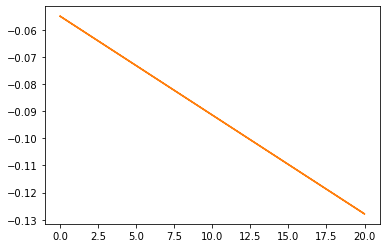

In [34]:
stats_simple = sm.OLS(y1, x)
results = stats_simple.fit()
print(results.summary())
m = results.params[1:]
b = results.params[0]
plt.plot(x, m*x+b)

0.0016863115540654006
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4088
Date:                Wed, 17 Aug 2022   Prob (F-statistic):              0.523
Time:                        14:57:57   Log-Likelihood:                -12.386
No. Observations:                 244   AIC:                             28.77
Df Residuals:                     242   BIC:                             35.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0563      0.0

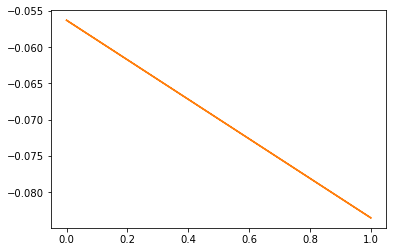

In [37]:
#Regression looking at whether there is a rally or not
#Get our x and y's
x = np.array(regression_df['rally']).reshape((-1, 1))
y1 = np.array(regression_df['total_avg'])
#Get our model and fit our model to the overall average
simple_model = LinearRegression().fit(x, y1)
#Get r^2
r_sq = simple_model.score(x, y1)
print(r_sq)
#Simple with stats model (total average)
x = sm.add_constant(x)
stats_simple = sm.OLS(y1, x)
results = stats_simple.fit()
print(results.summary())
m = results.params[1:]
b = results.params[0]
plt.plot(x, m*x+b)

### Make a nice plot of our regression prediction and the actual correlation

## Bag of words

In [12]:
tweets_for_bag = pd.read_csv('tweets_for_bag.csv')

In [14]:
tweets_for_bag.drop('Unnamed: 0', axis=1, inplace=True)
tweets_for_bag

,cleaned text,sentiment_score,date
0,prediction: every primetime host tonight will...,-0.6486,2021-02-05
1,i don't understand - since we all know the ele...,-0.4939,2021-02-05
2,trump2020,0.0000,2021-02-05
3,thank you for keeping the greatest president ...,0.8655,2021-02-05
4,i just found out that someone stole a bunch o...,0.5719,2021-02-05
...,...,...,...
172450,!democrats stink 💣 backfires! 👇 democrats paid...,-0.5080,2020-05-21
172451,announces charges against philadelphia electi...,-0.3818,2020-05-21
172452,"333+millionpopulation, 100,000+died =...",0.0000,2020-05-21
172453,strange 'cause trump mailed in his last vote...,-0.2023,2020-05-21


In [19]:
tfidf = TfidfVectorizer()
x = tweets_for_bag.copy().dropna(axis="rows")['cleaned text'].values
y = tweets_for_bag.copy().dropna(axis="rows")['sentiment_score'].values
for i in range(len(y)):
    if y[i] >= 0:
        y[i] = 1
    else:
        y[i] = 0        
x_bag = tfidf.fit_transform(x)

In [20]:
lr = LogisticRegression(random_state=0)
lr.fit(x_bag, y)

LogisticRegression(random_state=0)

In [22]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names_out()]

coefficients = lr.coef_

coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

,00,000,0000,00000,000000,000000189,000007,0000074,00003,00008,...,𝘰𝘶𝘳,𝙍𝙝𝙞𝙣𝙤𝙨,𝙎𝙞𝙙𝙣𝙚𝙮,𝙒𝙚,𝙔𝙤𝙪,𝙜𝙤,𝙡𝙤𝙫𝙚,𝙪𝘾𝙧𝙪𝙨𝙝,𝚏𝚛𝚊𝚞𝚍only,𝚠𝚒𝚍𝚎𝚜𝚙𝚛𝚎𝚊𝚍
0,0.300889,-0.615553,-0.10388,-0.011373,0.010995,0.137097,-0.067501,-0.037971,-0.005607,-0.251853,...,0.017884,0.018184,0.018184,0.018184,0.018184,0.018184,0.018184,0.018184,0.067439,0.067439


In [25]:
#20 best
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
#20 worst
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                   0
great      10.361311
love        8.663508
freedom     7.239193
supreme     6.821597
justice     6.643682
best        6.571576
won         6.510902
greatest    6.438194
thank       5.904870
free        5.735404
wow         5.705374
strong      5.602697
wins        5.467832
honest      5.310891
winner      5.285126
pretty      5.216120
integrity   5.204040
thanks      4.990372
save        4.971960
share       4.910241
                    0
fraud      -17.299535
steal      -12.174066
hell       -11.692673
dead       -11.220765
stealing    -9.984382
fraudulent  -9.935805
no          -9.786312
illegal     -9.768496
fake        -9.589859
war         -9.314387
stolen      -9.166430
bad         -8.771666
fight       -8.737655
cheating    -8.630817
evil        -8.421084
violence    -8.366461
bullshit    -7.734021
wrong       -7.663713
lying       -7.646235
failed      -7.589104


In [33]:
for i in range(len(tweets_for_bag['cleaned text'])):
    if 'justice' in tweets_for_bag['cleaned text'][i]:
        print(tweets_for_bag['cleaned text'][i])
        print(tweets_for_bag['sentiment_score'][i])
        print()

  my ass it's more like  i am writing a letter to the secretary of justice i want you charged with treason,&amp; thrown in jaili call for a citizen's arrest     ,&amp; all his liar pimps need to go to jail
-0.5434

  no bueno!touching those machines while ignoring an az senate subpoena is "obstruction of justice"! !!
-0.7243

  touching those machines while ignoring an az senate subpoena is "obstruction of justice"! !!
-0.5538

so the maricopa county, az audit revealed massive election fraud and they don't want the az state senate (and the country) to find outobstruction of justice is in itself evidence!this is my county and my vote that was stolen!!  
-0.6906

obstruction of justice continues in arizona!maricopa county, az executives have grabbed and are manipulating the dominion voting machines before the az legislature's forensic audit!  criminals!!    
-0.6083

wife of  justice apologizing for her endorsement of the  rally that led to the  
0.6597

who else saw graphic images of hu

TypeError: argument of type 'float' is not iterable

In [31]:
tweets_for_bag

,cleaned text,sentiment_score,date
0,prediction: every primetime host tonight will...,-0.6486,2021-02-05
1,i don't understand - since we all know the ele...,-0.4939,2021-02-05
2,trump2020,0.0000,2021-02-05
3,thank you for keeping the greatest president ...,0.8655,2021-02-05
4,i just found out that someone stole a bunch o...,0.5719,2021-02-05
...,...,...,...
172450,!democrats stink 💣 backfires! 👇 democrats paid...,-0.5080,2020-05-21
172451,announces charges against philadelphia electi...,-0.3818,2020-05-21
172452,"333+millionpopulation, 100,000+died =...",0.0000,2020-05-21
172453,strange 'cause trump mailed in his last vote...,-0.2023,2020-05-21
